In [127]:
!pip freeze > requirements.txt

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

In [129]:
dataset = pd.read_csv('appointment_data.csv')

In [130]:
#divisione in classi età
def age_division(dataset):
    
    dataset= dataset.copy()

    age = np.asanyarray(dataset['Age'])
 
    for i in range(0, age.size):
        if 0 <= age[i] <= 20:
            age[i] = 0
        elif 21 <= age[i] <= 40:
            age[i] = 1
        elif 41 <= age[i] <= 90:
            age[i] = 2
        else:
            age[i] = 3
            
    dataset['Age'] = pd.DataFrame(age)
    
    return dataset

In [131]:
def days_of_waiting(dataset):
    
    dataset= dataset.copy()

    waiting_days= []

    for i in range(dataset.shape[0]):

        data_Scheduled, ora_Scheduled= dataset['ScheduledDay'].loc[i].split('T')
        data_Appointment, ora_Appointment= dataset['AppointmentDay'].loc[i].split('T')

        annoS, meseS, giornoS= data_Scheduled.split('-')
        annoA, meseA, giornoA= data_Appointment.split('-')

        months_difference= (int(meseA)-int(meseS))*30 #ipotizzo tutti i mesi di 30

        if(int(annoS)==int(annoA)):
            if(int(meseS)==int(meseA)):
                if(int(giornoS)==int(giornoA)):
                    waiting_days.append(0)
                else:
                    waiting_days.append(abs(int(giornoA)-int(giornoS)))
            else:
                waiting_days.append(abs(int(giornoA)+months_difference-int(giornoS)))
        else:
            years_difference= (int(annoA)-int(annoS))*365
            waiting_days.append(abs(int(giornoA)+months_difference+years_difference-int(giornoS)))                        

    dataset['days_of_waiting'] = waiting_days
    
    return dataset

Text(0.5, 1, 'Correlation between different features')

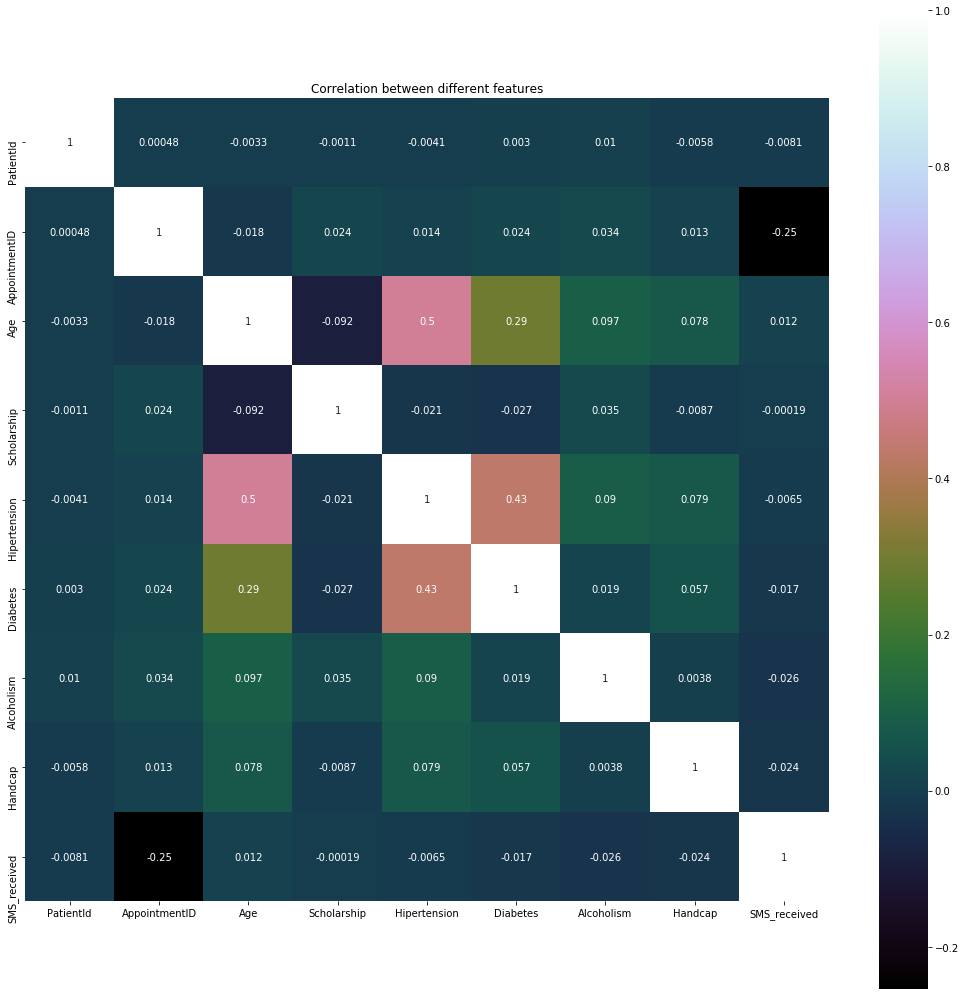

In [132]:
#heatmap per la selezione delle features     
correlation = dataset.corr()
plt.figure(figsize=(18,18))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')
plt.title('Correlation between different features')

In [133]:
def transf(dataset):
    
    dataset= dataset.copy()
    
    dataset= age_division(dataset)
    dataset= days_of_waiting(dataset)
    
    dataset = dataset.drop(columns=['AppointmentDay','AppointmentID','Gender','Neighbourhood','PatientId','ScheduledDay'])
    
    return dataset

In [134]:
train_csv = pd.read_csv('train.csv')

In [135]:
test_csv = pd.read_csv('test.csv')

In [136]:
train = transf(train_csv.copy())
test = transf(test_csv.copy())

In [137]:
    
features_categoriche = dataset.select_dtypes(include = 'object')
    
label_encoder = LabelEncoder()

train['No-show'] = label_encoder.fit_transform(train['No-show'])
test['No-show'] = label_encoder.fit_transform(test['No-show'])

In [138]:
Y_train, Y_test = train['No-show'], test['No-show']
X_train, X_test = train.drop(columns=['No-show']), test.drop(columns=['No-show'])

In [139]:
tr = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=5)


#fit e prediction
tr.fit(X_train, Y_train)
pred = tr.predict(X_test)
print('Accuracy:',accuracy_score(Y_test, pred))

Accuracy: 0.8031099802092169
